# Diabetes Dataset Classification

LOAD DATA

In [1]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)
y = diabetes_data["Diabetes_binary"]

# Transform the dataset into numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()



In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)


### LDA classification

In [4]:
# classification
class_means,class_cov = functions.LDA_classifier_train_cov(X_train, Y_train,2)
predicted_labels = functions.LDA_classifier_predict_cov(X_test,class_means,class_cov,2)


In [5]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train,Y_train,X_test,Y_test, class_means, class_cov, functions.LDA_classifier_predict_cov)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

training_accuracy : 0.7444943761168926
test_accuracy : 0.7431212551245664
Confusion Matrix:
 [[32540 11127]
 [ 1906  5163]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.75      0.83     43667
         1.0       0.32      0.73      0.44      7069

    accuracy                           0.74     50736
   macro avg       0.63      0.74      0.64     50736
weighted avg       0.86      0.74      0.78     50736



### QDA classification

In [6]:
# using QDA classifier
class_means,cov = functions.QDA_classifier_train(X_train, Y_train,2)
predicted_labels = functions.QDA_classifier_predict(X_test,class_means,cov,2)

In [7]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train,Y_train,X_test,Y_test, class_means, cov, functions.QDA_classifier_predict)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

training_accuracy : 0.6553926206244087
test_accuracy : 0.6553729107537054
Confusion Matrix:
 [[27451 16216]
 [ 1269  5800]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.63      0.76     43667
         1.0       0.26      0.82      0.40      7069

    accuracy                           0.66     50736
   macro avg       0.61      0.72      0.58     50736
weighted avg       0.86      0.66      0.71     50736



### Logistic Regression

In [8]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))

# Confusion Matrix
predicted_labels = pipeline.predict(X_test)
cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)


Accuracy: 0.862050614947966
Confusion Matrix:
 [[42607  1060]
 [ 5939  1130]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.92     43667
         1.0       0.52      0.16      0.24      7069

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736



### Random Forest

In [9]:
# training of the model and prediction
Y_pred = functions.RF_pred(X_train, Y_train, X_test)

# accuracy
functions.RF_accuracy(Y_test, Y_pred)

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, Y_pred)
print("Classification Report:\n", cr)

RF accuracy: 0.86
Confusion Matrix:
 [[42341  1326]
 [ 5898  1171]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.47      0.17      0.24      7069

    accuracy                           0.86     50736
   macro avg       0.67      0.57      0.58     50736
weighted avg       0.82      0.86      0.83     50736



### Neural Net

In [22]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [23]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [24]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

C:\Users\anais\.miniconda\envs\LAB_3.11\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 14.1417  Train acc 70.03% | Val loss 14.0938  Val acc 73.25%
[Epoch   5/50] LR 1.000e-03 | Train loss 14.0433  Train acc 72.79% | Val loss 14.0664  Val acc 72.14%
[Epoch  10/50] LR 1.000e-03 | Train loss 14.0336  Train acc 72.91% | Val loss 14.0692  Val acc 71.67%
[Epoch  15/50] LR 1.000e-04 | Train loss 14.0128  Train acc 73.65% | Val loss 14.0660  Val acc 72.82%
[Epoch  20/50] LR 1.000e-04 | Train loss 14.0101  Train acc 73.34% | Val loss 14.0680  Val acc 72.99%
[Epoch  25/50] LR 1.000e-05 | Train loss 14.0083  Train acc 73.43% | Val loss 14.0680  Val acc 72.99%
[Epoch  30/50] LR 1.000e-06 | Train loss 14.0095  Train acc 73.44% | Val loss 14.0680  Val acc 73.00%
[Epoch  35/50] LR 1.000e-07 | Train loss 14.0081  Train acc 73.44% | Val loss 14.0680  Val acc 73.00%
[Epoch  40/50] LR 1.000e-08 | Train loss 14.0108  Train acc 73.44% | Val loss 14.0680  Val acc 73.00%
[Epoch  45/50] LR 1.000e-08 | Train loss 14.0074  Train acc 73.44% | Val loss 14.0

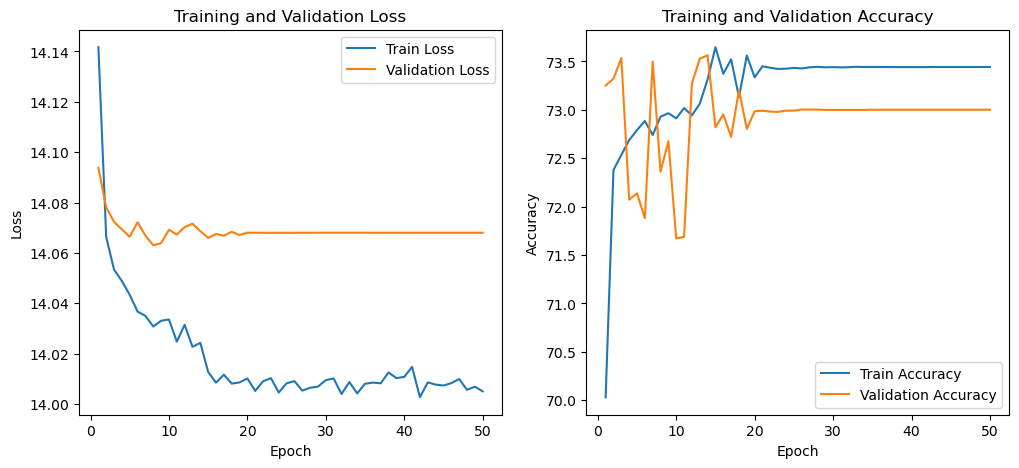

In [25]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test set
accuracy = functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor, device)
print("Test accuracy:\n", accuracy)

# Confusion Matrix
predicted_labels = (model.forward(X_test_tensor.to(device)).detach().cpu() > 0.5).int().squeeze()

cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

Test accuracy:
 0.7300141911069064
Confusion Matrix:
 [[31524 12143]
 [ 1555  5514]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     43667
         1.0       0.31      0.78      0.45      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736



### Neural Net with rebalanced dataset


In [15]:
##### We balance the dataset classes using RandomOverSampler ####

from sklearn.utils import resample

# Separate majority and minority classes in the training set
mask_min = Y_train == 1
X_min, y_min = X_train[mask_min], Y_train[mask_min]
X_maj, y_maj = X_train[~mask_min], Y_train[~mask_min]

# Upsample minority to match majority size
n_maj = len(y_maj)
X_min_upsampled, y_min_upsampled = resample(
    X_min, y_min,
    replace=True,
    n_samples=n_maj,
    random_state=42
)

# Combine and shuffle
X_train_balanced = np.vstack([X_maj, X_min_upsampled])
Y_train_balanced = np.hstack([y_maj, y_min_upsampled])

perm = np.random.RandomState(42).permutation(len(Y_train_balanced))
X_train_balanced = X_train_balanced[perm]
Y_train_balanced = Y_train_balanced[perm]

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = (
    scaled_tensorize_data(
        X_train_balanced,
        Y_train_balanced,
        X_val, Y_val,
        X_test, Y_test
    )
)

In [16]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [17]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

C:\Users\anais\.miniconda\envs\LAB_3.11\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 53.1076  Train acc 74.81% | Val loss 14.1058  Val acc 67.11%
[Epoch   5/50] LR 1.000e-03 | Train loss 52.9869  Train acc 75.66% | Val loss 14.1002  Val acc 67.73%
[Epoch  10/50] LR 1.000e-03 | Train loss 52.9631  Train acc 75.91% | Val loss 14.1142  Val acc 66.64%
[Epoch  15/50] LR 1.000e-04 | Train loss 52.9284  Train acc 76.22% | Val loss 14.1067  Val acc 67.51%
[Epoch  20/50] LR 1.000e-05 | Train loss 52.9228  Train acc 76.30% | Val loss 14.1032  Val acc 67.84%
[Epoch  25/50] LR 1.000e-06 | Train loss 52.9247  Train acc 76.32% | Val loss 14.1035  Val acc 67.82%
[Epoch  30/50] LR 1.000e-06 | Train loss 52.9235  Train acc 76.32% | Val loss 14.1035  Val acc 67.83%
[Epoch  35/50] LR 1.000e-07 | Train loss 52.9249  Train acc 76.32% | Val loss 14.1035  Val acc 67.83%
[Epoch  40/50] LR 1.000e-08 | Train loss 52.9237  Train acc 76.32% | Val loss 14.1035  Val acc 67.83%
[Epoch  45/50] LR 1.000e-08 | Train loss 52.9299  Train acc 76.32% | Val loss 14.1

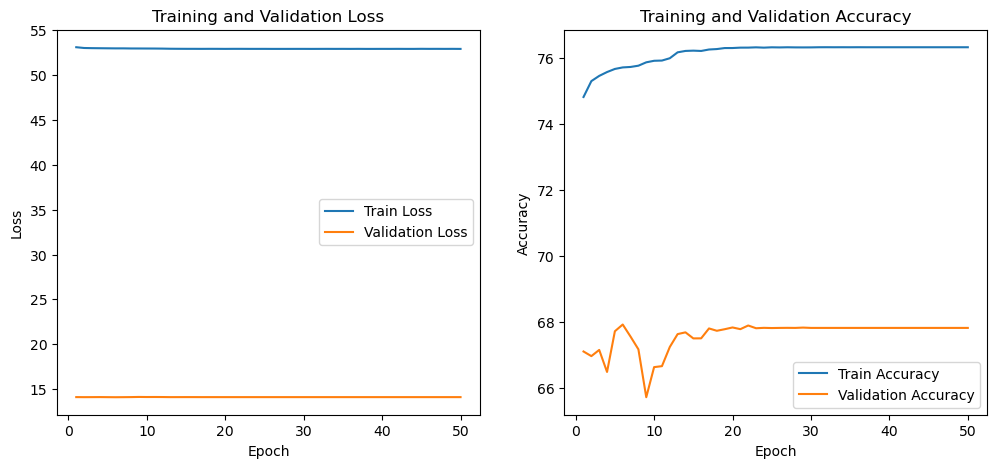

In [18]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [20]:
# Evaluate the model on the test set
accuracy = functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor, device)
print("Test accuracy:\n", accuracy)

# Confusion Matrix
predicted_labels = (model.forward(X_test_tensor.to(device)).detach().cpu() > 0.5).int().squeeze()

cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

Test accuracy:
 0.6782757805108799
Confusion Matrix:
 [[28455 15212]
 [ 1111  5958]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.65      0.78     43667
         1.0       0.28      0.84      0.42      7069

    accuracy                           0.68     50736
   macro avg       0.62      0.75      0.60     50736
weighted avg       0.87      0.68      0.73     50736



### Conclusion

When we look at the results that we have, we can clearly see that most of the models used for the classification tend to classify the non sick data points pretty well but tend to really struggle to correctly classify the sick data points as they are the minority class by a factor of about 10.

The Neural Network on the other hand, can correctly classify the sick data points but also makes about 10 times as much false positives which really isn't ideal. This could be fixed with changes to the neural network like adding more hidden layers or raising the amount of neurons in each hidden layer. 

The Neural Network that was trained on a rebalanced dataset exhibits similar performance but with a bit worse accuracy and confusion matrix which is surprising since balancing the dataset should've helped it be better at classifying the data points.

To conclude, if we wanna minimize the amount of false negative, we should look at using the MLP.
If we wanna minimize the amount of false positive, we should loot at using the Random Forest algorithm